In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

In [3]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints),
    reactions,
    cache = True
)

In [53]:
r = deck[0].reactants[0]
generator = designer.generator(r)

In [434]:
%%time
import torch

molecules = [deck[18].reactants[1]]

# Identify analogs of each original molecule
indices, scores, sizes = designer.generator.fingerprint_similarity(molecules)

# Add size similarity to score
original_sizes = torch.tensor([m.mol.GetNumAtoms() for m in molecules])
l1_norm = sizes - original_sizes[:, None]
scores += designer.generator.size_similarity(molecules, sizes)
samples_idx = torch.argsort(scores, descending=True)
samples = torch.gather(indices, 1, samples_idx).tolist()
# bbs = [designer.generator.building_blocks[s] for s in samples[0][:50]]

CPU times: user 0 ns, sys: 6.22 ms, total: 6.22 ms
Wall time: 6.25 ms


CPU times: user 74.3 ms, sys: 0 ns, total: 74.3 ms
Wall time: 79.4 ms


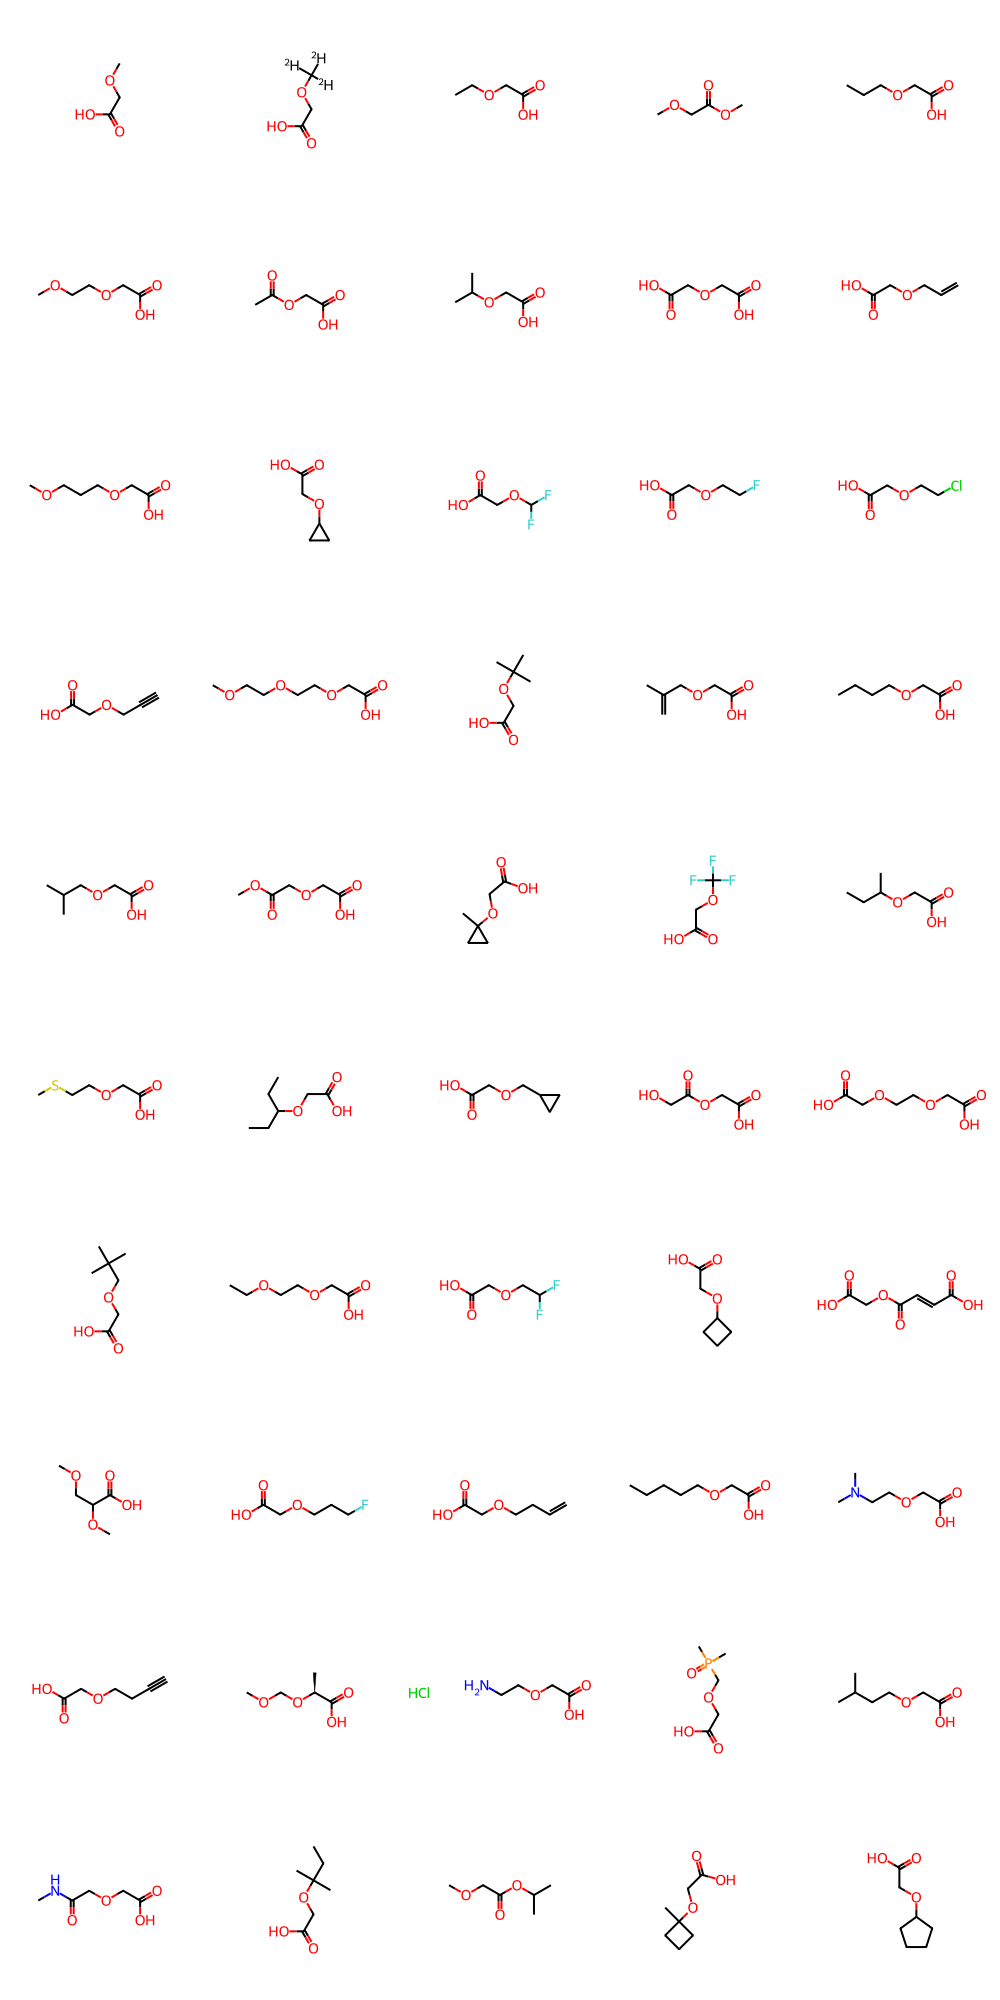

In [436]:
%%time
prods = []
for idx, i in enumerate(samples[0]):
    bb = designer.generator.building_blocks[i]
    if bb.HasSubstructMatch(molecules[0].mol):
        prods.append(bb)

from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage(prods, molsPerRow=5)

In [444]:
# Unbiased sample of indices
probabilities = torch.ones([1, len(designer.generator.building_blocks)])
samples = torch.multinomial(probabilities, 200).tolist()[0]
prods = [designer.generator.building_blocks[s] for s in samples]

In [503]:
fps = [
    designer.generator.fingerprints.random_choice()
    for _ in range(10)
]

for fp in fps:
    designer.generator.fingerprints.get_index_by_id(mol[0])

CPU times: user 65.4 ms, sys: 0 ns, total: 65.4 ms
Wall time: 70.5 ms


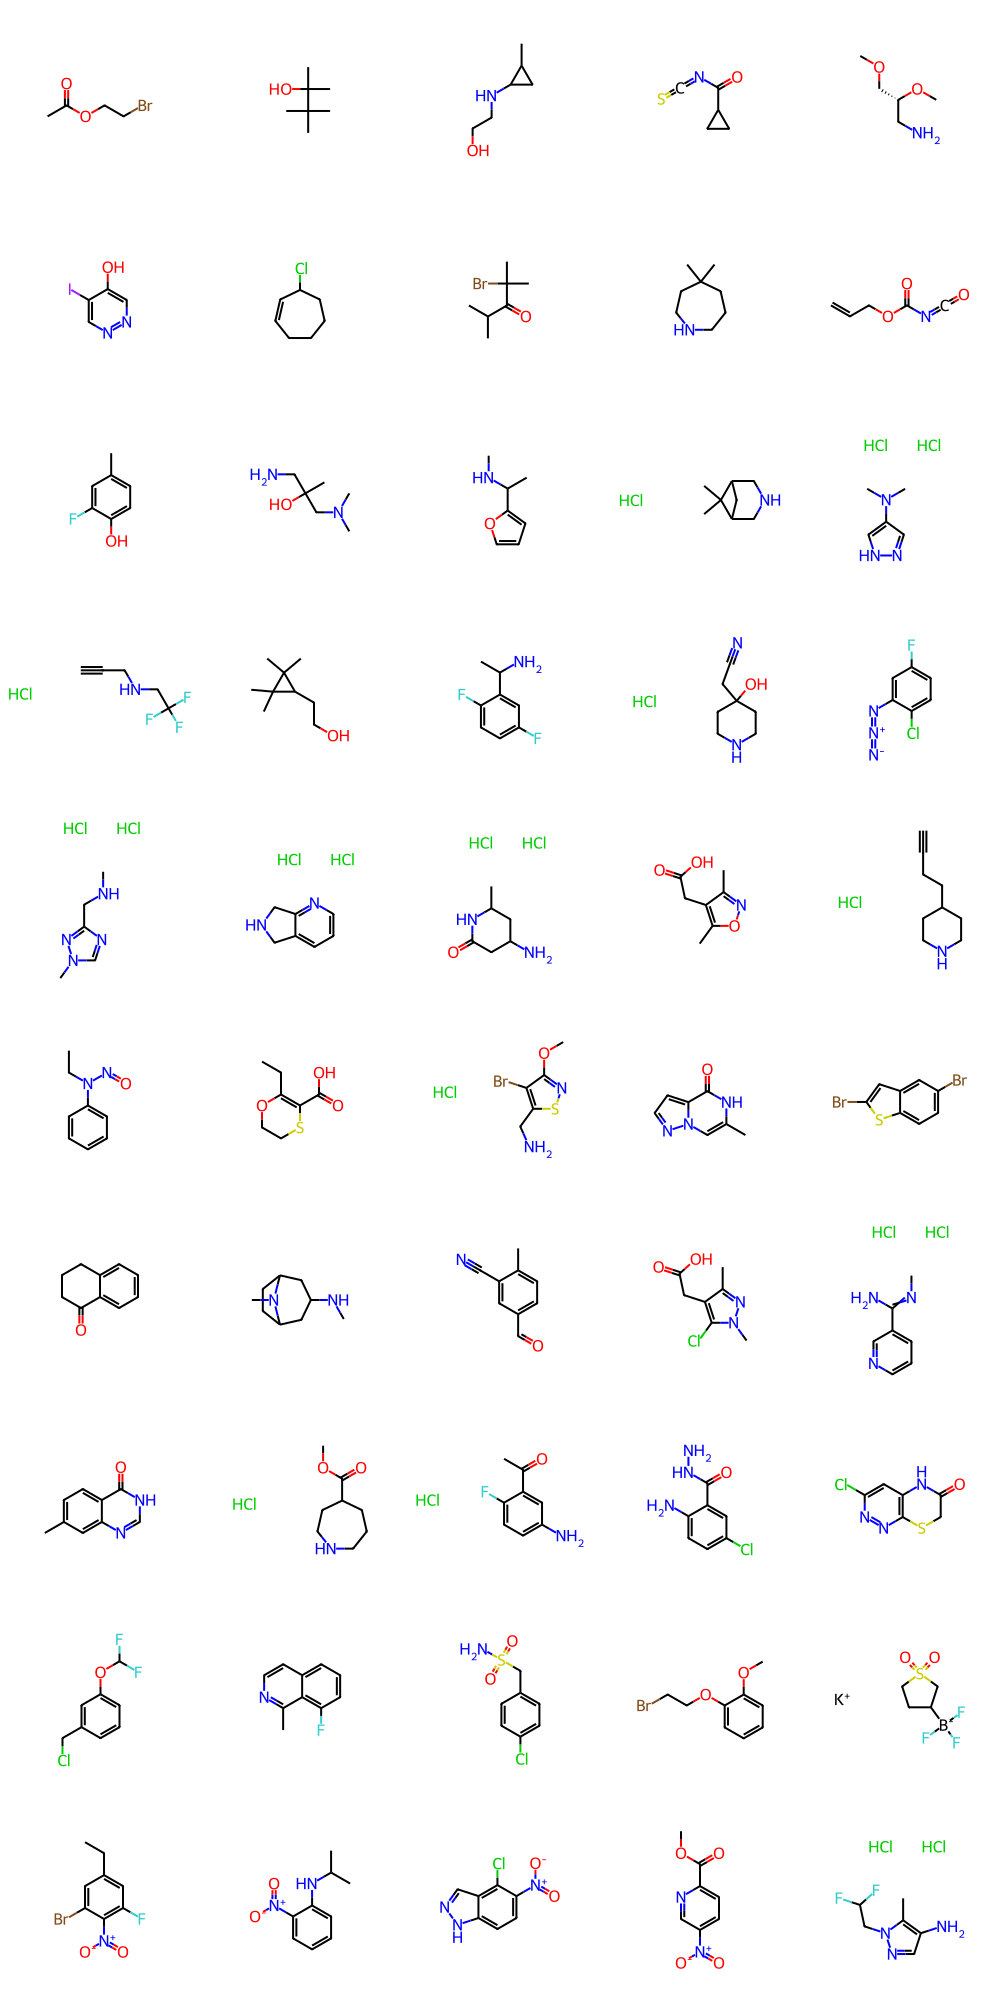

In [660]:
%%time
ids = designer.generator.fingerprints.sample(100).ids
indices = [designer.generator.fingerprints.get_index_by_id(id) for id in ids]
get_size = lambda ids: [int(i.split(' ')[-1]) for i in ids]
sizes = get_size(ids)

import numpy as np
res = np.array(indices)[np.argsort(sizes)]
prods = [designer.generator.building_blocks[r] for r in res.tolist()]

from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage(prods, molsPerRow=5)